# Autoregressive model using OLS

In this notebook we will use Ordinary Least Square (OLS) to fit a linear model to time series data. OLS is a general modelling approach and is not designed specifically with time series in mind.  However, it is easy to adapt and use with autoregressive data.  There are two caveats 

<div class="alert alert-success">
    
1. Unlike purpose built time series models such as ARIMA we need to preprocess the data beforehand.

2. Forecasting **h-steps** ahead is more involved than other methods.
</div>

 
However, OLS itself is very simple to use and the procedures we develop to solve 1 and 2 are exactly what we need to work with Feedforward Neural Networks and Recurrent Neural Networks which we will cover later.

---
**LEARNING OBJECTIVES**

* Mechanics of fitting time series data to an OLS autoregressive model
* Generate h-step forecasts using an iterative approach
* Generate prediction intervals for an OLS autoregressive model

---


## 1. Python dependencies

It is recommended that you use the forecasting course conda environment provided for this work.  The implementation of Ordinary Least Squares Regression that we are going to use is in `statsmodels`.  You should be using at least version `0.11.1`

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sm.__version__

'0.11.1'

The `statsmodels` package has a class for OLS that we are going to use.

```python 
statsmodels.regression.linear_model.OLS 
```

In [2]:
from statsmodels.regression.linear_model import OLS

## 2. AR OLS: The forecasting process

1. Select $l$ the number of autoregressive lags and forecast horizon $h$
2. Preprocess the data into tabular form [[$lag_1, lag_2, ... lag_l$], [$y_t$]]
3. Fit the OLS model to the tabular data
4. Iteratively forecast 1-step ahead gradually replacing ground truth observations with predictions.


### 2.1 Synthetic data without noise

Given the extra complexities of forecasting using OLS we will use simple synthetic data before exploring real healthcare data. The synthetic data we wil use is a cosine.  

In [3]:
t = np.arange(200)
ts_data = np.cos(0.2 * t)

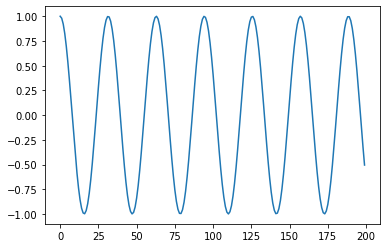

In [4]:
plt.plot(ts_data);

## 2.2. Preprocess the time series into tabular autoregressive form

An autoregressive model consists of $l$ lags of the time series. 

An easy way to think about the form of the data for a autoregressive OLS model is as a table of variables.  The first $l$ columns are the lags (the independent predictor variables) and the final column is $y$ at time $t$ ($y_t$) that is, the target/dependent variable.  

We there need to manipulate the time series so that is now in that format.  More precisely for each row we need: 

**A vector presenting the lags at time t**
* $X_t = $ [$lag_{t-l}, ... lag_{t-2}, lag_{t-1}$]

**A scalar value representing y at time t:**
* $y_t$

For training we need a vector of rows ($X_t$) and vector of target $y_t$. e.g.

```python
X_train = [X_1, X_2, X_3, ...,  X_t]

y_train = [y_1, y_2, y_3, ..., y_t]
```
---

The function `sliding_window` illustrates how to preprocess time series data into tabular form  in python.

In [5]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=1)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    for i in range(0, len(train) - window_size - horizon + 1):
        X_train = train[i:window_size+i]
        y_train = train[i+window_size:window_size+i+horizon]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
        
    return np.asarray(tabular_X), np.asarray(tabular_y)

In [6]:
#Let's do a train test split first
train = ts_data[:175]
test = ts_data[175:]

#preprocess time series training and test sets
X_train, y_train = sliding_window(train, window_size=2)
X_test, y_test = sliding_window(test, window_size=2)

In [7]:
print(X_train.shape)
print(y_train.shape)

(173, 2)
(173, 1)


The preprocessing included 2 lags.  So let's have a look at how the first elements in `X_train` and `y_train` compare to the first three elements of `ts_data`

In [8]:
print(f'ts_data[:3]: {ts_data[:3]}')
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

ts_data[:3]: [1.         0.98006658 0.92106099]
X_train[0]: [1.         0.98006658]
y_train[0]: [0.92106099]


Just to prove this is work let's manually slide out window of lag size 2 along `ts_data` to see how it compares with the next element in `X_train` and `y_train`

In [9]:
print(f'ts_data[1:4]: {ts_data[1:4]}')
print(f'X_train[1]: {X_train[1]}')
print(f'y_train[1]: {y_train[1]}')

ts_data[1:4]: [0.98006658 0.92106099 0.82533561]
X_train[1]: [0.98006658 0.92106099]
y_train[1]: [0.82533561]


## 2.3 Fit the preprocessed data to the OLS model

After preprocessing the data, fitting the data is relatively straightforward.  We create an instance of `OLS` passing in the training data and call the `.fit()` method.  The method fit returns a `RegressionResults` object that we use for prediction.  We can called the `.summary()` method to see the fitted model.

In [10]:
X_train = sm.add_constant(X_train)
model = OLS(endog=y_train, exog=X_train).fit()

#see the regression results (not the adj. R squared!)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.380e+31
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        15:57:33   Log-Likelihood:                 5632.4
No. Observations:                 173   AIC:                        -1.126e+04
Df Residuals:                     170   BIC:                        -1.125e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.689e-17   1.35e-16     -0.199      0.842   -2.94e-16     2.4e-16
x1            -1.0000   9.62e-16  -1.04e+15      0.000      -1.000      -1.000
x2             1.9601   9.62e-16   2.04e+15      0.000       1.960       1.960
==============================================================================
Omnibus:                       25.455   Durbin-Watson:                   3.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.658
Skew:                           0.003   Prob(JB):                     5.82e-35
Kurtosis:                       7.677   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2.4 Forecasting 1 step ahead

To forecast 1-step ahead we use the `RegressionResults` method `.predict(exog)`.  For example if we wanted to forecast the first y observation in the test set.

In [11]:
X_test = sm.add_constant(X_test)
pred = model.predict(exog=X_test[0])[0]
print(f'1-step forecast: {pred}')
print(f'ground trust value: {y_test[0][0]}')


1-step forecast: -0.665613455333755
ground trust value: -0.6656134553337595


An alternative way to call predict is to use `.get_prediction(exog)` to get a `PredictionResults` object.  This has the nice method `.summary_frame(alpha=0.05)` that can be used to get a dataframe complete with prediction interval.

In [12]:
results = model.get_prediction(exog=X_test[0])
results.summary_frame(alpha=0.2)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-0.665613,2.379594e-16,-0.665613,-0.665613,-0.665613,-0.665613


## 2.4 Forecast h periods ahead using the iterative method.

**We have trained our `OLS` model to predict 1-step** ahead by regressing the previous two observations in the time series.  When forecasting 2 or more steps ahead we still only have two ground truth observations ($lag_1$ and $lag_2$). This means that when forecasting h-steps ahead we need to do this in a loop where we iteratively replace our ground truth observations with our predictions.

In [13]:
current_X = np.array([1, 2, 3, 4])
current_X = np.roll(current_X, shift=-1)
current_X

array([2, 3, 4, 1])

In [14]:
y_pred = 999
current_X = np.array([1, 2, 3, 4])
current_X = np.roll(current_X, shift=-1)
current_X[-1] = y_pred
current_X


array([  2,   3,   4, 999])

In [15]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        y_pred = model.predict(current_X)[0]
        y_preds.append(y_pred)

        current_X = np.roll(current_X, shift=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [16]:
H = 5
y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
print(f'Iterative forecast: {y_preds}')
print(f'Ground truth y: {y_test[:H].T[0]}')

Iterative forecast: [-0.66561346 -0.50407924 -0.32244898 -0.12796369  0.07162311]
Ground truth y: [-0.66561346 -0.50407924 -0.32244898 -0.12796369  0.07162311]


#### Adding some noise

To make this a bit more interesting we will add some normally distributed noise to the synthetic time series.

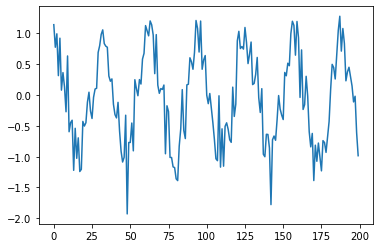

In [17]:
#set the random seed so that we all get the same results
np.random.seed(12)
t = np.arange(200)
ts_data = np.cos(0.2 * t)
noise = np.random.normal(loc=0.0, scale=0.3, size=200)
ts_data = ts_data + noise
plt.plot(ts_data);

In [18]:
def select_model_via_aic(train, test, window_sizes):  
    best = {'aic':np.Inf,
            'model': None,
            'ws': None}
    
    for ws in window_sizes:
    
        #preprocess time series training and test sets
        X_train, y_train = sliding_window(train, window_size=ws)
        X_test, y_test = sliding_window(test, window_size=ws)

        X_train = sm.add_constant(X_train)
        model = OLS(endog=y_train, exog=X_train).fit()
        
        if model.aic < best['aic']:
            best['aic'] = model.aic
            best['model'] = model
            best['ws'] = ws
            
    return best

In [19]:
ws = [i for i in range(2, 20, 2)]
print(f'Window sizes to test {ws}')

#train test split 150 and 50
train, test = ts_data[:150], ts_data[150:]

best = select_model_via_aic(train, test, ws)
print(f"lags included: {best['ws']}")

Window sizes to test [2, 4, 6, 8, 10, 12, 14, 16, 18]
lags included: 18


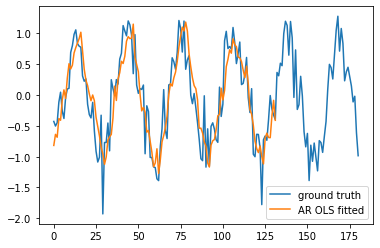

In [21]:
plt.plot(ts_data[best['ws']+1:], label='ground truth')
plt.plot(model.fittedvalues, label='AR OLS fitted')
plt.legend();

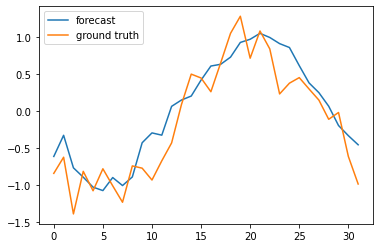

In [29]:
#setup test data
ws = best['ws']

#preprocess time series training and test sets
X_train, y_train = sliding_window(train, window_size=ws)
X_test, y_test = sliding_window(test, window_size=ws)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = OLS(endog=y_train, exog=X_train).fit()

#make iterative predictions
H = len(y_test)
y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)

#plot
plt.plot(y_preds, label='forecast')
plt.plot(y_test, label='ground truth')
plt.legend()